In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import skopi as sk
import numpy as np
import os, time
import scipy.ndimage
import skopi.gpu as pg
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy import stats

In [19]:
args = dict()
args['pdb_file'] = "/sdf/home/a/apeck/skopi/examples/input/pdb/3iyf.pdb"
args['beam_file'] = "/sdf/home/a/apeck/skopi/examples/input/beam/amo86615.beam"
args['geom_file'] = "/sdf/home/a/apeck/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data"
args['increase_factor'] = 1e3

In [20]:
# generate beam
beam = sk.Beam(args['beam_file'])
beam.set_photons_per_pulse(args['increase_factor']*beam.get_photons_per_pulse())

# generate detector
det = sk.PnccdDetector(geom=args['geom_file'], beam=beam)
det.distance = 0.2

# generate particle
particle = sk.Particle()
particle.read_pdb(args['pdb_file'], ff='WK')

In [21]:
# use same orientation for each shot
quats = sk.get_random_quat(1)
quats = np.tile(quats,2).reshape(2,4)

In [22]:
# sase parameters
n_spikes, sigma = 30, 10

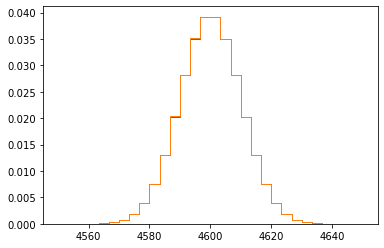

In [23]:
imgs = dict()

# SPI of single spike
exp = sk.SPIExperiment(det, beam, particle)
exp.set_orientations(quats)
imgs['normal'] = exp.generate_image()
imgs['inormal'] = exp.generate_image_stack(return_intensities=True)

# SPI of SASE spike
sbeam = sk.SASEBeam(mu=beam.photon_energy, sigma=sigma, n_spikes=n_spikes, fname=args['beam_file'])
sbeam.set_photons_per_pulse(args['increase_factor']*sbeam.get_photons_per_pulse())
exp = sk.SPIExperiment(det, sbeam, particle)
exp.set_orientations(quats)
imgs['sase'] = exp.generate_image()
imgs['isase'] = exp.generate_image_stack(return_intensities=True)

for key in ['inormal','isase']:
    imgs[key] = det.assemble_image_stack(imgs[key])

Text(0.5, 1.0, 'Difference map')

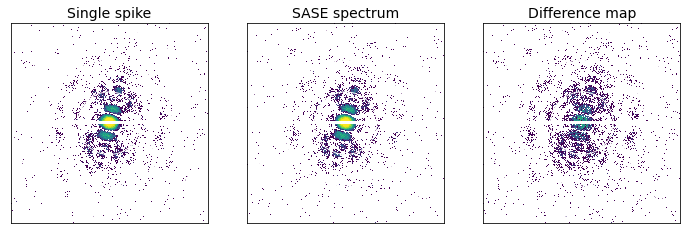

In [24]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4))

norm = colors.LogNorm(vmin=1, vmax=0.5*imgs['normal'].max())
for key,ax in zip(['normal','sase'],[ax1,ax2]):
    ax.imshow(imgs[key].T, origin='lower', interpolation='None', norm=norm)#, vmax=20*np.mean(imgs['normal']))
ax3.imshow(np.abs(imgs['normal'].T - imgs['sase'].T), origin='lower', interpolation='None', norm=norm)

    
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
    # add diffraction rings
    center = 0.5*np.array(imgs['normal'].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,4)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 1.05-0.06*i

        ax.add_patch(Circle(center, pix_rad, edgecolor='white', fill=False))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(center[0]+label_pos*pix_rad, center[1]-label_pos*pix_rad),
                               ha="center", va="bottom", color="white", fontsize=12)

ax1.set_title("Single spike", fontsize=14)
ax2.set_title("SASE spectrum", fontsize=14)
ax3.set_title("Difference map", fontsize=14)

Text(0.5, 1.0, 'Difference map')

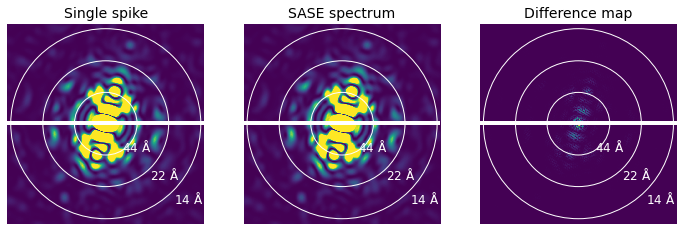

In [25]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4))

norm = colors.LogNorm(vmin=1e-3, vmax=1000*np.max(imgs['normal']))
for key,ax in zip(['inormal','isase'],[ax1,ax2]):
    ax.imshow(imgs[key].T, origin='lower', interpolation='None', vmax=1.5*np.mean(imgs['inormal']))
ax3.imshow(np.abs(imgs['inormal'].T - imgs['isase'].T), origin='lower', interpolation='None', vmax=1.5*np.mean(imgs['inormal']))

    
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
    # add diffraction rings
    center = 0.5*np.array(imgs['normal'].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,4)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 1.05-0.06*i

        ax.add_patch(Circle(center, pix_rad, edgecolor='white', fill=False))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(center[0]+label_pos*pix_rad, center[1]-label_pos*pix_rad),
                               ha="center", va="bottom", color="white", fontsize=12)
        
    rect = patches.Rectangle((0,512), 1045, 20, facecolor='white')
    ax.add_patch(rect)
    ax.axis('off')

ax1.set_title("Single spike", fontsize=14)
ax2.set_title("SASE spectrum", fontsize=14)
ax3.set_title("Difference map", fontsize=14)

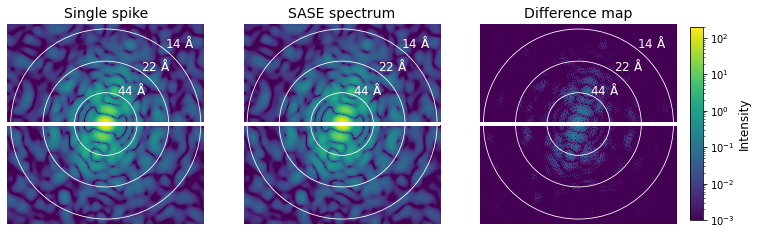

In [69]:
s_mags = det.assemble_image_stack(det.pixel_distance_reciprocal)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4))

norm = colors.LogNorm(vmin=1e-3, vmax=np.max(imgs['normal']))
for key,ax in zip(['inormal','isase'],[ax1,ax2]):
    ax.imshow(imgs[key].T, origin='lower', interpolation='None', norm=norm)
im = ax3.imshow(np.abs(imgs['inormal'].T - imgs['isase'].T), origin='lower', interpolation='None', norm=norm)

cbar_ax = f.add_axes([0.915, 0.17, 0.015, 0.67])
cb = f.colorbar(im, cax=cbar_ax)
cb.set_label("Intensity", fontsize=12)

    
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
    # add diffraction rings
    center = 0.5*np.array(imgs['inormal'].T.shape)[::-1]
    s_start = s_mags.max() * 0.68
    steps = range(1,4)
    for i in steps:
        q = i*s_start/steps[-1]
        s = q/(2*beam.wavenumber)
        pix_rad = det.distance * 2 * s * np.sqrt(1-s**2) / (1-2*s**2) / np.mean(det.pixel_width)
        resolution = 1e10/q
        label_pos = 0.85*(1-0.03*i)

        ax.add_patch(Circle(center, pix_rad, edgecolor='white', fill=False, linewidth=0.8))
        ax.annotate("%i $\mathrm{\AA}$"%resolution, xy=(label_pos*pix_rad+center[0], label_pos*pix_rad+center[1]),
                               ha="center", va="bottom", color="white", fontsize=12)
        
    rect = patches.Rectangle((0,512), 1045, 20, facecolor='white')
    ax.add_patch(rect)
    ax.axis('off')

ax1.set_title("Single spike", fontsize=14)
ax2.set_title("SASE spectrum", fontsize=14)
ax3.set_title("Difference map", fontsize=14)

f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/beam/patterns_logI.png", bbox_inches='tight', dpi=300)

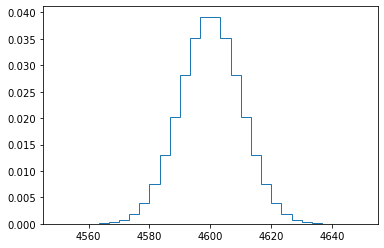

In [27]:
spikes = sbeam.generate_new_state()

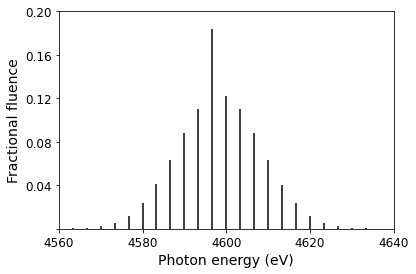

In [67]:
f, ax1 = plt.subplots(figsize=(6,4))

mu=beam.photon_energy

energy = []
flux = []
for i in range(n_spikes):
    energy.append(spikes[i].photon_energy)
    flux.append(spikes[i].get_photons_per_pulse())

samples = np.random.normal(mu, sigma, n_spikes)

# Kernel Density Estimation (KDE)
gkde = stats.gaussian_kde(samples)
ind = np.linspace(mu-50, mu+50, n_spikes+1)
gkde.set_bandwidth(bw_method='scott') # bw_method = scott, silverman, gkde.factor/3., gkde.factor/4., etc.
kdepdf = gkde(ind)

# Visualization
ax1.vlines(energy, 0, flux / np.array(flux).sum(), color="black")
ax1.set_xlabel('Photon energy (eV)', fontsize=14)
ax1.set_ylabel('Fractional fluence', fontsize=14)
ax1.set_yticks(np.arange(0,0.24,0.04))
ax1.set_yticklabels(["","0.04","0.08","0.12","0.16","0.20"], fontsize=12)
ax1.set_xticks(range(4560,4620+40,20))
ax1.set_xticklabels(range(4560,4620+40,20), fontsize=12)
ax1.set_xlim(4560,4640)
ax1.set_ylim(0,0.2)

f.savefig("/sdf/home/a/apeck/exafel/skopi_figs/beam/spectrum.png", bbox_inches='tight', dpi=300)